# Atividade Aprendizagem de Máquina - Spark MLLib

Considerando o dataset detalhado a seguir, aplique as técnicas solicitadas

### Dataset dados de sensores veicular

- Dados relativos a sensores de internet das coisas (IoT) para detecção de estados dos medidores


| #  	| Nome do campo           	| Descrição                                                                     	|
|----	|-------------------------	|-------------------------------------------------------------------------------	|
| 0  	| Hora               	| Hora média das medições                                                          	|
| 1  	| Minuto         	| Minuto médio das medições                                               	|
| 2  	| Temp_minima         	| Temperatura mínima das medições                                               	|
| 3  	| Temp_maxima         	| Temperatura máxima das medições                                               	|
| 4  	| Latitude_media  	| Latitude média das medições                             	|
| 5  	| Longitude_media  	| Longitude média das medições                             	|
| 6  	| Classe  	| Estado do medidor (Frio, Moderado, Quente, Alerta)                             	|


**Informações a serem extraídas:**

1. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
2. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
3. Determine qual a quantidade de eventos não Alerta (label = 0.0, ou label = 1.0, ou label = 2.0) classificados erroneamente como classe Alerta (falso-positivo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
4. Faça votação entre os classificadores da etapa 1.A, 1.B e 1.C para atribuir a classe do evento de acordo com a maioria das classes entre os classificadores
    - Dicas: Para isto, voce irá precisar fazer o join das predições de cada classificador de acordo com os IDs dos eventos. Posteriormente voce pode manipular o dataframe, após o join, para determinar qual classe de cada evento possuiu maior votação =). Exemplo de código:
```python

    import pyspark.sql.functions as func
    
    predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                        func.col('label'),
                        func.col('id'))\
    .join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                        func.col('id')), ['id'])
```
5. Considerando que voce possui apenas duas classes: Não Alerta e Alerta. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 20 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=20 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
        - Dicas: Para isto, você irá precisar manipular o dataframe para alterar os valores da coluna label, por exemplo através de uma UDF
6. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores do item 5
7. Faça busca de parametros dos classificadores desenvolvidos no item 5. Plote um gráfico relacionando a acurácia e os parametros otimizados
    1. Árvore de Decisão varie o parametro maxDepth de 1 a 20
    2. Random Forest varie o numTrees de 1 a 20

**Dicas:**
- *Crie uma célula (Insert -> Insert Cell Below) para cada informação solicitada*
- *A análise deve ser feita sobre os dados do HDFS*
- *Inicialize o seu cluster executando o script em: Desktop/ambientes/spark/inicializar.sh*
- *Acesse o seu cluster executando o script em: Desktop/ambientes/spark/abrir_navegador.sh*

In [2]:
#instala pyspark no google colab
!pip install pyspark==3.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 19.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845494 sha256=aacdacbffb8fe94dc0c9bd2d018a722346fc2ecf44b5c6ed9b9c2343bff9162d
  Stored in directory: /root/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# abre sessão no spark sql
from pyspark.sql import SparkSession

sc = SparkSession \
    .builder \
    .master('local[*]') \
    .getOrCreate()

In [4]:
#Efetua download do arquivo covid
!gdown 1-lSo7A-SIuntho9tAqVO25enmLlxFe7S
!gdown 1-iG4e4-SzJONLi3Nw98nm9UdFzoqCHDI

Downloading...
From: https://drive.google.com/uc?id=1-lSo7A-SIuntho9tAqVO25enmLlxFe7S
To: /content/treinamento.csv
100% 26.1M/26.1M [00:00<00:00, 72.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-iG4e4-SzJONLi3Nw98nm9UdFzoqCHDI
To: /content/teste.csv
100% 37.4M/37.4M [00:00<00:00, 42.3MB/s]


In [5]:
dfTreino = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('file:////content/treinamento.csv')

dfTeste = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('file:////content/teste.csv')

In [6]:
dfTreino.printSchema()

root
 |-- hora: double (nullable = true)
 |-- minuto: double (nullable = true)
 |-- temp_minima: double (nullable = true)
 |-- temp_maxima: double (nullable = true)
 |-- latitude_media: double (nullable = true)
 |-- longitude_media: double (nullable = true)
 |-- Classe: string (nullable = true)



In [7]:
from pyspark.sql.functions import monotonically_increasing_id

dfTeste = dfTeste.withColumn('id', monotonically_increasing_id())
dfTeste.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
only showing top 5 rows



In [8]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

dfTreino = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTreino)\
    .transform(dfTreino)

dfTreino = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTreino)

dfTreino.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|11.312758|30.169239|     -1.859|     27.495|     36.169994|      139.23022|Moderado|  0.0|[11.312758,30.169...|
|11.292323|29.638779|   8.542997|  36.177994|     31.349113|       73.50964|  Quente|  3.0|[11.292323,29.638...|
|11.600304| 29.64275|     -1.861|  27.695002|      36.17158|      139.22937|Moderado|  0.0|[11.600304,29.642...|
|11.462425|30.157314|   9.776998|  36.077995|     31.351593|        73.5104|  Quente|  3.0|[11.462425,30.157...|
|11.735474|  29.9684|     -1.662|  27.695002|     36.169456|      139.23021|Moderado|  0.0|[11.735474,29.968...|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+-----

In [9]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

dfTeste = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTeste)\
    .transform(dfTeste)

dfTeste = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTeste)

In [10]:
#informação 1.A
from pyspark.ml.classification import DecisionTreeClassifier
import pyspark.sql.functions as func

dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
modeloDT = dt.fit(dfTreino)

In [11]:
predicaoDT = modeloDT.transform(dfTeste)
predicaoDT.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoDT)

0.9424338788317617

In [26]:
#informação 1.B
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=20)
modeloRF = rf.fit(dfTreino)

In [27]:
predicaoRF = modeloRF.transform(dfTeste)
predicaoRF.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [28]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF)

0.944573906981833

In [20]:
#informação 1.C
from pyspark.ml.classification import RandomForestClassifier

rf100 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100)
modeloRF100 = rf100.fit(dfTreino)

In [21]:
predicaoRF100 = modeloRF100.transform(dfTeste)
predicaoRF100.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [22]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF100)

0.9473597470777757

In [18]:
#informação 2.A
predicaoDT = modeloDT.transform(dfTeste)

falso_negativo_DT = predicaoDT.filter((predicaoDT.label == 3.0) & (predicaoDT.prediction != 3.0))
falso_negativo_DT.count()

12735

In [29]:
#informação 2.B
predicaoRF = modeloRF.transform(dfTeste)

falso_negativo_RF = predicaoRF.filter((predicaoRF.label == 3.0) & (predicaoRF.prediction != 3.0))
falso_negativo_RF.count()

17514

In [24]:
#informação 2.C
predicaoRF100 = modeloRF100.transform(dfTeste)

falso_negativo_RF100 = predicaoRF100.filter((predicaoRF100.label == 3.0) & (predicaoRF100.prediction != 3.0))
falso_negativo_RF100.count()

16308

In [30]:
#informação 3.A
predicaoDT = modeloDT.transform(dfTeste)

falso_positivo_DT1 = predicaoDT.filter((predicaoDT.label == 1.0) & (predicaoDT.prediction != 1.0))
falso_positivo_DT2 = predicaoDT.filter((predicaoDT.label == 0.0) & (predicaoDT.prediction != 0.0))
falso_positivo_DT0 = predicaoDT.filter((predicaoDT.label == 2.0) & (predicaoDT.prediction != 2.0))
falso_positivo_DT0.count() + falso_positivo_DT2.count() + falso_positivo_DT1.count()

20403

In [32]:
#informação 3.B
predicaoRF = modeloRF.transform(dfTeste)

falso_positivo_RF1 = predicaoRF.filter((predicaoRF.label == 1.0) & (predicaoRF.prediction != 1.0))
falso_positivo_RF2 = predicaoRF.filter((predicaoRF.label == 0.0) & (predicaoRF.prediction != 0.0))
falso_positivo_RF0 = predicaoRF.filter((predicaoRF.label == 2.0) & (predicaoRF.prediction != 2.0))
falso_positivo_RF0.count() + falso_positivo_RF2.count() + falso_positivo_RF1.count()

13905

In [33]:
#informação 3.C
predicaoRF100 = modeloRF100.transform(dfTeste)

falso_positivo_RF1001 = predicaoRF100.filter((predicaoRF100.label == 1.0) & (predicaoRF100.prediction != 1.0))
falso_positivo_RF1002 = predicaoRF100.filter((predicaoRF100.label == 0.0) & (predicaoRF100.prediction != 0.0))
falso_positivo_RF1000 = predicaoRF100.filter((predicaoRF100.label == 2.0) & (predicaoRF100.prediction != 2.0))
falso_positivo_RF1000.count() + falso_positivo_RF1002.count() + falso_positivo_RF1001.count()

13590

In [34]:
#informação 4
rf5 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=5)
modeloRF5 = rf5.fit(dfTreino)
predicaoRF5 = modeloRF5.transform(dfTeste)

rf100 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100)
modeloRF100 = rf100.fit(dfTreino)
predicaoRF100 = modeloRF100.transform(dfTeste)

In [37]:
df_votacao = predicaoDT.select(func.col('prediction').alias('prediction_dt'), func.col('id'))\
.join(predicaoRF5.select(func.col('prediction').alias('prediction_rf5'), func.col('id')), ['id'])\
.join(predicaoRF100.select(func.col('prediction').alias('prediction_rf100'), func.col('id')), ['id'])


df_votacao = df_votacao.withColumn('prediction_majority', func.expr("""
CASE
    WHEN prediction_dt + prediction_rf5 + prediction_rf100 >= 2 THEN 1.0
    ELSE 0.0
END
"""))

df_votacao.show(10)

+---+-------------+--------------+----------------+-------------------+
| id|prediction_dt|prediction_rf5|prediction_rf100|prediction_majority|
+---+-------------+--------------+----------------+-------------------+
|  0|          0.0|           0.0|             0.0|                0.0|
|  1|          0.0|           0.0|             0.0|                0.0|
|  5|          0.0|           0.0|             0.0|                0.0|
|  6|          0.0|           0.0|             0.0|                0.0|
|  7|          0.0|           0.0|             0.0|                0.0|
|  9|          0.0|           0.0|             0.0|                0.0|
| 10|          0.0|           0.0|             0.0|                0.0|
| 17|          0.0|           0.0|             0.0|                0.0|
| 19|          0.0|           0.0|             0.0|                0.0|
| 22|          0.0|           0.0|             0.0|                0.0|
+---+-------------+--------------+----------------+-------------

In [78]:
#informação 5
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Defina sua função para mapear as classes
def mapear_classe(classe):
    if classe == 'Alerta':
        return 3.0
    else:
        return 0.0

# Crie uma UDF a partir da sua função
udf_mapear_classe = udf(mapear_classe, FloatType())

# Aplique a UDF para criar uma nova coluna 'label'
dfTreino = dfTreino.withColumn('label', udf_mapear_classe(dfTreino['Classe']))
dfTeste = dfTeste.withColumn('label', udf_mapear_classe(dfTeste['Classe']))

dfTeste.show(10)

+---------+---------+-----------+-----------+--------------+---------------+----------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|    classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+----------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Não Alerta|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Não Alerta|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Não Alerta|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Não Alerta|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Não Alerta|  4|  0.0|[11.4008,29.42228...|
| 11.50784| 29.18513|      1.423|  29.106003|   

In [59]:
#informação 5.A
predicaoDT = modeloDT.transform(dfTeste)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

evaluator.evaluate(predicaoDT)

0.307063231704473

In [60]:
#informação 5.B
predicaoRF = modeloRF.transform(dfTeste)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

evaluator.evaluate(predicaoRF)

0.3085091497069295

In [61]:
#informação 5.C
predicaoRF100 = modeloRF.transform(dfTeste)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

evaluator.evaluate(predicaoRF100)

0.3085091497069295

In [62]:
#informação 6
predicaoDT = modeloDT.transform(dfTeste)

falso_negativo_DT = predicaoDT.filter((predicaoDT.label == 3.0) & (predicaoDT.prediction != 3.0))
falso_negativo_DT.count()

160443

In [63]:
predicaoRF = modeloRF.transform(dfTeste)

falso_negativo_RF = predicaoRF.filter((predicaoRF.label == 3.0) & (predicaoRF.prediction != 3.0))
falso_negativo_RF.count()

162945

In [64]:
predicaoRF100 = modeloRF100.transform(dfTeste)

falso_negativo_RF100 = predicaoRF100.filter((predicaoRF100.label == 3.0) & (predicaoRF100.prediction != 3.0))
falso_negativo_RF100.count()

162837

In [82]:
#informação 7
from pyspark.sql.functions import when

dfTreino = dfTreino.withColumn('Classe', when(dfTreino['Classe'] == 'Alerta', 'Alerta').otherwise('Não Alerta'))
dfTeste = dfTeste.withColumn('Classe', when(dfTeste['Classe'] == 'Alerta', 'Alerta').otherwise('Não Alerta'))

dfTeste.show(10)

+---------+---------+-----------+-----------+--------------+---------------+----------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|    Classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+----------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Não Alerta|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Não Alerta|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Não Alerta|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Não Alerta|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Não Alerta|  4|  0.0|[11.4008,29.42228...|
| 11.50784| 29.18513|      1.423|  29.106003|   

In [83]:
#informação 7.A
import matplotlib.pyplot as plt

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
acuracias = []

# Varie o parâmetro maxDepth de 1 a 20
for depth in range(1, 21):
    dt.setMaxDepth(depth)
    modelo = dt.fit(dfTreino)
    predicoes = modelo.transform(dfTeste)
    acuracia = evaluator.evaluate(predicoes)
    acuracias.append(acuracia)

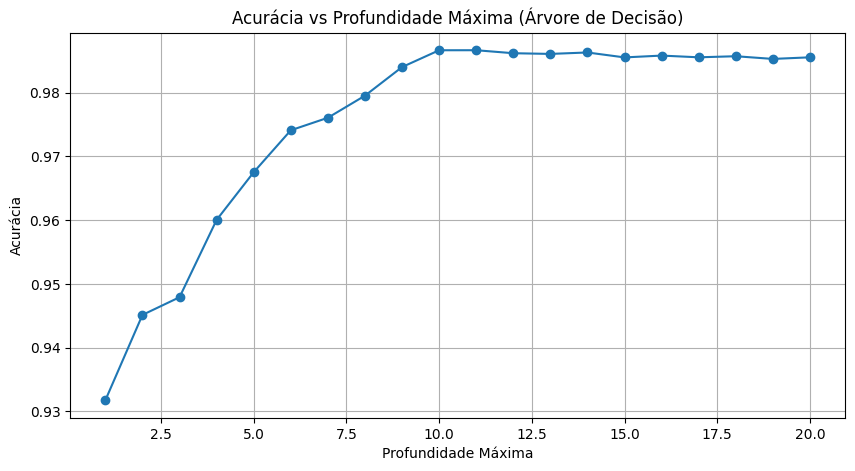

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), acuracias, marker='o')
plt.title('Acurácia vs Profundidade Máxima (Árvore de Decisão)')
plt.xlabel('Profundidade Máxima')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

In [85]:
#informação 7.B
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
acuracias = []

for num in range(1, 21):
    rf.setNumTrees(num)
    modelo = rf.fit(dfTreino)
    predicoes = modelo.transform(dfTeste)
    acuracia = evaluator.evaluate(predicoes)
    acuracias.append(acuracia)

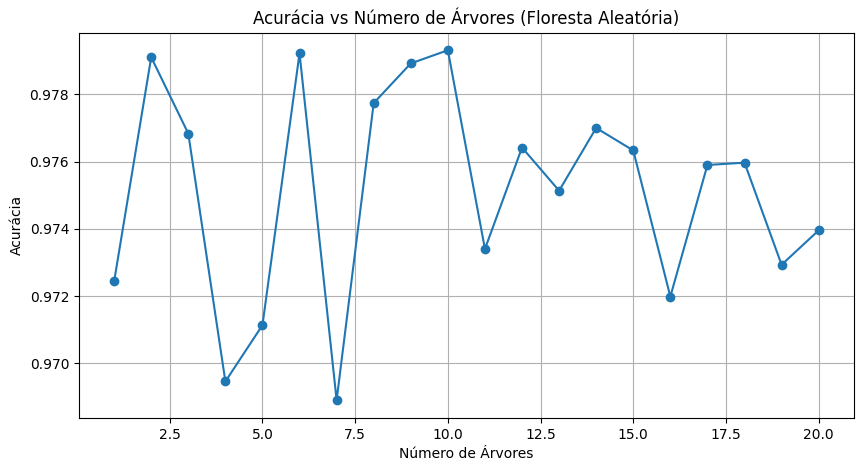

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), acuracias, marker='o')
plt.title('Acurácia vs Número de Árvores (Floresta Aleatória)')
plt.xlabel('Número de Árvores')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()